In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_validate
import sys
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import statistics
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE

# Defining train_model function

In [16]:
def train_model(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    smote = SMOTE(sampling_strategy='auto')
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    base_model = DecisionTreeClassifier(random_state=42)
    model = AdaBoostClassifier(base_model, n_estimators=1000, random_state=42)
    model.fit(X_train, y_train)
    scoring = {
        'recall0': make_scorer(recall_score, average = None, labels = [0]),
        'recall1': make_scorer(recall_score, average = None, labels = [1]),
        'recall2': make_scorer(recall_score, average = None, labels = [2]),
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'roc_auc': make_scorer(roc_auc_score, average='weighted', multi_class='ovr', needs_proba=True),
        'f1_score': make_scorer(f1_score, average='weighted')
    }

    kfold = KFold(n_splits=10, shuffle=True, random_state=42)

    results = cross_validate(estimator=model, X=X_train, y=y_train, cv=kfold, scoring = scoring,  n_jobs=-1)
    predictions = model.predict(X_test)
    predictions_2 = model.predict_proba(X_test)

    return results, model, predictions, y_test, X_test, predictions_2

In [17]:
def calculate_metrics(y_test, predictions, predictions_2):
    test_accuracy = accuracy_score(y_test, predictions)
    test_precision = precision_score(y_test, predictions, average='weighted')
    test_recall = recall_score(y_test, predictions, average='weighted')
    test_roc_auc = roc_auc_score(y_test, predictions_2,  multi_class='ovr')
    test_f1 = f1_score(y_test, predictions, average='weighted')
    
    metrics_dict = {
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_roc_auc': test_roc_auc,
        'test_f1': test_f1
    }
    return metrics_dict

# Main code

In [18]:
# Read dataset
df = pd.read_csv(r'output_combined.csv')
# Prep the dataset
df = df.dropna()
df = df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1)
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.dayofyear
df = df.drop(df.index[-1])
replacement_dict = {'Non': 0, 'NPF': 1, 'undefined': 2}
df['day.type'] = df['day.type'].replace(replacement_dict)
df_orig = df

# Iteration 1

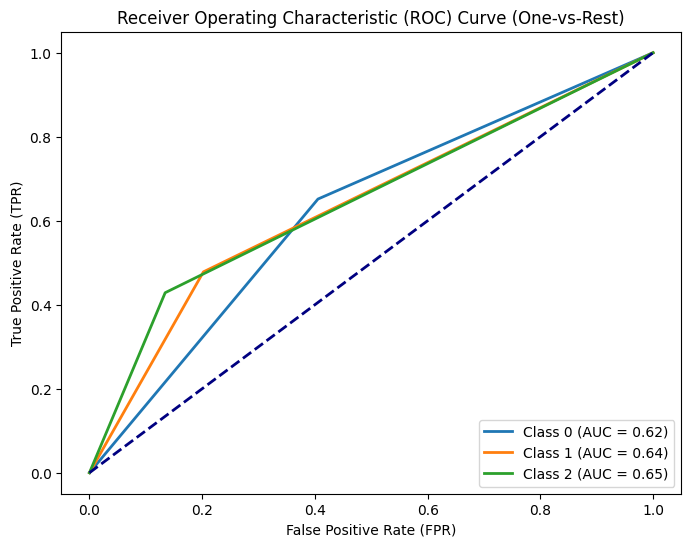

In [22]:
df_selected = df_orig[["pressure", "RH", "temperature", "SWD", "day.type"]].copy()
df = df_selected
# Split dataset
X = df.drop(columns=["day.type"])
y = df["day.type"]
# Unpack results
results, model, predictions, y_test, X_test, predictions_2 = train_model(X=X, y=y)
metrics = calculate_metrics(y_test, predictions, predictions_2)
# Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
average_roc_auc = statistics.mean(results.get('test_roc_auc', [None]))
average_f1 = statistics.mean(results.get('test_f1_score', [None]))
stdev_accuracy = statistics.stdev(results['test_accuracy'])
average_recall0 = statistics.mean(results.get('test_recall0', [None]))
average_recall1 = statistics.mean(results.get('test_recall1', [None]))
average_recall2 = statistics.mean(results.get('test_recall2', [None]))

# Visualize feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Redirect stdout to a file
with open('adb_regular_combination_0.txt', 'w') as file:
    sys.stdout = file 
    print("Accuracies: ", np.array2string(results['test_accuracy'], separator=', '))
    print("Precisions: ", np.array2string(results['test_precision'], separator=', '))
    print("Recalls: ", np.array2string(results['test_recall'], separator=', '))
    print('-----------------------------------------------------------------------------------------------')
    print("Average Accuracy:", average_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)

    print("Average Roc_auc score:", average_roc_auc)
    print("Average F1 score:", average_f1)

    print("Average non-NPF recall:", average_recall0)
    print("Average NPF recall:", average_recall1)
    print("Average Undefined recall:", average_recall2)
    print('-----------------------------------------------------------------------------------------------')
    print("test_accuracy", metrics['test_accuracy'])
    print("test_precision", metrics['test_precision'])
    print("test_recall", metrics['test_recall'])
    print("test_roc_auc", metrics['test_roc_auc'])
    print("test_f1", metrics['test_f1'])

    print("Feature Importance:")
    print(feature_importance_df)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test to one-hot encoding
y_test_onehot = pd.get_dummies(y_test)
# Calculate ROC curve for each class
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot.iloc[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
# plt.show()
plt.savefig('adb_regular_ROC_combination_0.png', dpi=300) 

# Iteration 2

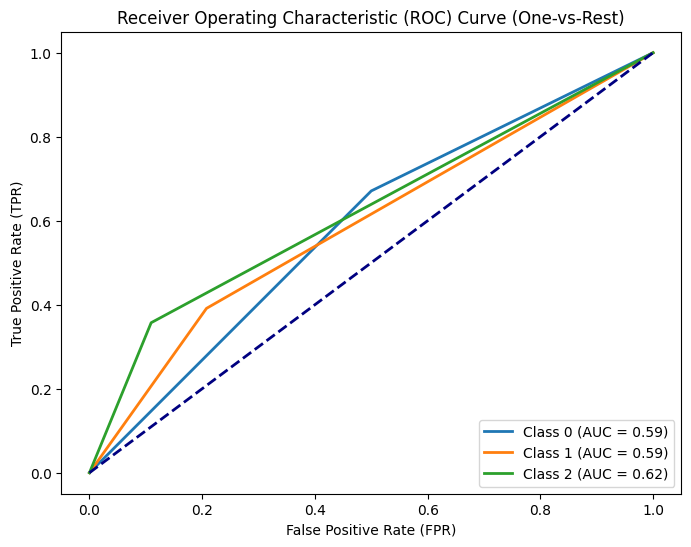

In [21]:
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type"]].copy()
df = df_selected
# Split dataset
X = df.drop(columns=["day.type"])
y = df["day.type"]
# Unpack results
results, model, predictions, y_test, X_test, predictions_2 = train_model(X=X, y=y)
metrics = calculate_metrics(y_test, predictions, predictions_2)
# Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
average_roc_auc = statistics.mean(results.get('test_roc_auc', [None]))
average_f1 = statistics.mean(results.get('test_f1_score', [None]))
stdev_accuracy = statistics.stdev(results['test_accuracy'])
average_recall0 = statistics.mean(results.get('test_recall0', [None]))
average_recall1 = statistics.mean(results.get('test_recall1', [None]))
average_recall2 = statistics.mean(results.get('test_recall2', [None]))

# Visualize feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Redirect stdout to a file
with open('adb_regular_combination_1.txt', 'w') as file:
    sys.stdout = file 
    print("Accuracies: ", np.array2string(results['test_accuracy'], separator=', '))
    print("Precisions: ", np.array2string(results['test_precision'], separator=', '))
    print("Recalls: ", np.array2string(results['test_recall'], separator=', '))
    print('-----------------------------------------------------------------------------------------------')
    print("Average Accuracy:", average_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)

    print("Average Roc_auc score:", average_roc_auc)
    print("Average F1 score:", average_f1)

    print("Average non-NPF recall:", average_recall0)
    print("Average NPF recall:", average_recall1)
    print("Average Undefined recall:", average_recall2)
    print('-----------------------------------------------------------------------------------------------')
    print("test_accuracy", metrics['test_accuracy'])
    print("test_precision", metrics['test_precision'])
    print("test_recall", metrics['test_recall'])
    print("test_roc_auc", metrics['test_roc_auc'])
    print("test_f1", metrics['test_f1'])

    print("Feature Importance:")
    print(feature_importance_df)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test to one-hot encoding
y_test_onehot = pd.get_dummies(y_test)
# Calculate ROC curve for each class
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot.iloc[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
# plt.show()
plt.savefig('adb_regular_ROC_combination_1.png', dpi=300)

# Iteration 3

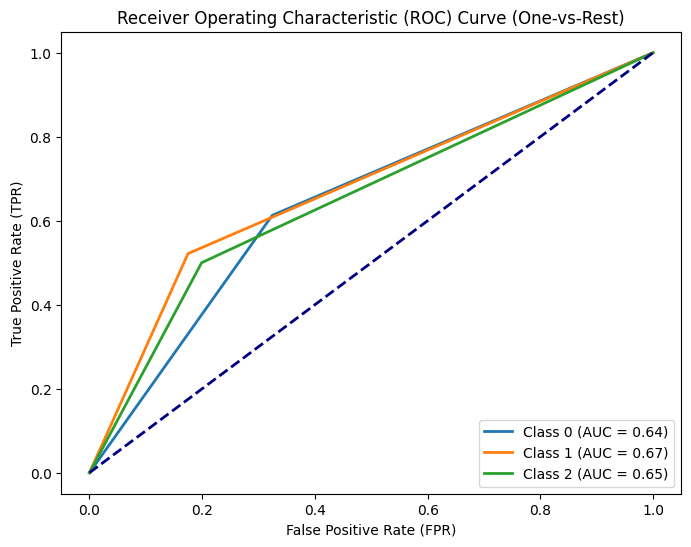

In [20]:
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type", "NH3", "SO4"]].copy()
df = df_selected
# Split dataset
X = df.drop(columns=["day.type"])
y = df["day.type"]
# Unpack results
results, model, predictions, y_test, X_test, predictions_2 = train_model(X=X, y=y)
metrics = calculate_metrics(y_test, predictions, predictions_2)
# Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
average_roc_auc = statistics.mean(results.get('test_roc_auc', [None]))
average_f1 = statistics.mean(results.get('test_f1_score', [None]))
stdev_accuracy = statistics.stdev(results['test_accuracy'])
average_recall0 = statistics.mean(results.get('test_recall0', [None]))
average_recall1 = statistics.mean(results.get('test_recall1', [None]))
average_recall2 = statistics.mean(results.get('test_recall2', [None]))

# Visualize feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Redirect stdout to a file
with open('adb_regular_combination_2.txt', 'w') as file:
    sys.stdout = file 
    print("Accuracies: ", np.array2string(results['test_accuracy'], separator=', '))
    print("Precisions: ", np.array2string(results['test_precision'], separator=', '))
    print("Recalls: ", np.array2string(results['test_recall'], separator=', '))
    print('-----------------------------------------------------------------------------------------------')
    print("Average Accuracy:", average_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)

    print("Average Roc_auc score:", average_roc_auc)
    print("Average F1 score:", average_f1)

    print("Average non-NPF recall:", average_recall0)
    print("Average NPF recall:", average_recall1)
    print("Average Undefined recall:", average_recall2)
    print('-----------------------------------------------------------------------------------------------')
    print("test_accuracy", metrics['test_accuracy'])
    print("test_precision", metrics['test_precision'])
    print("test_recall", metrics['test_recall'])
    print("test_roc_auc", metrics['test_roc_auc'])
    print("test_f1", metrics['test_f1'])

    print("Feature Importance:")
    print(feature_importance_df)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test to one-hot encoding
y_test_onehot = pd.get_dummies(y_test)
# Calculate ROC curve for each class
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot.iloc[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
# plt.show()
plt.savefig('adb_regular_ROC_combination_2.png', dpi=300)

# Iteration 4

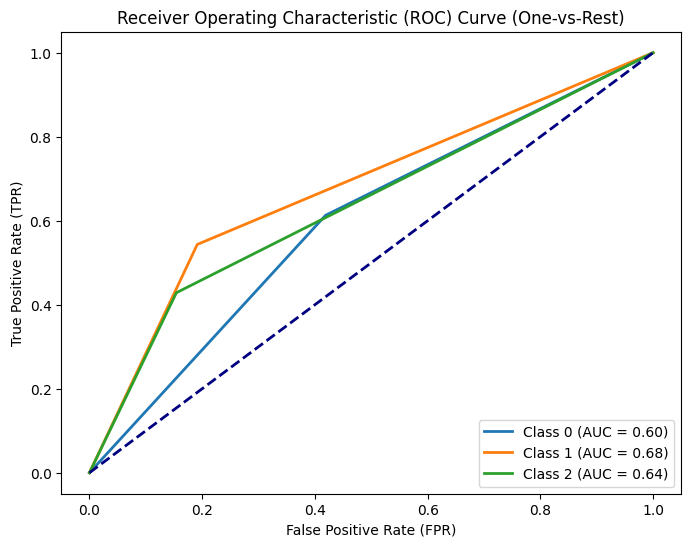

In [19]:
# Split dataset
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type", "NH3", "SO4", "NH4", "SO2"]].copy()
df = df_selected
X = df.drop(columns=["day.type"])
y = df["day.type"] 
# Unpack results
results, model, predictions, y_test, X_test, predictions_2 = train_model(X=X, y=y)
metrics = calculate_metrics(y_test, predictions, predictions_2)
# Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
average_roc_auc = statistics.mean(results.get('test_roc_auc', [None]))
average_f1 = statistics.mean(results.get('test_f1_score', [None]))
stdev_accuracy = statistics.stdev(results['test_accuracy'])
average_recall0 = statistics.mean(results.get('test_recall0', [None]))
average_recall1 = statistics.mean(results.get('test_recall1', [None]))
average_recall2 = statistics.mean(results.get('test_recall2', [None]))

# Visualize feature importances
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Redirect stdout to a file
with open('adb_regular_combination_3.txt', 'w') as file:
    sys.stdout = file 
    print("Accuracies: ", np.array2string(results['test_accuracy'], separator=', '))
    print("Precisions: ", np.array2string(results['test_precision'], separator=', '))
    print("Recalls: ", np.array2string(results['test_recall'], separator=', '))
    print('-----------------------------------------------------------------------------------------------')
    print("Average Accuracy:", average_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)

    print("Average Roc_auc score:", average_roc_auc)
    print("Average F1 score:", average_f1)

    print("Average non-NPF recall:", average_recall0)
    print("Average NPF recall:", average_recall1)
    print("Average Undefined recall:", average_recall2)
    print('-----------------------------------------------------------------------------------------------')
    print("test_accuracy", metrics['test_accuracy'])
    print("test_precision", metrics['test_precision'])
    print("test_recall", metrics['test_recall'])
    print("test_roc_auc", metrics['test_roc_auc'])
    print("test_f1", metrics['test_f1'])

    print("Feature Importance:")
    print(feature_importance_df)
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test to one-hot encoding
y_test_onehot = pd.get_dummies(y_test)
# Calculate ROC curve for each class
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot.iloc[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
# plt.show()
plt.savefig('adb_regular_ROC_combination_3.png', dpi=300)